In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
import torch
from PIL import Image
import numpy as np

import os
from datetime import datetime
import matplotlib.pyplot as plt

import math
import shutil
from google.colab import drive
from PIL import Image

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Konstantos**


1.   ```LOAD_CHECKPOINT``` - switch to True to load existing checkpoint from path
2.   ```USE_SUBSET``` - switch to True to use a part of dataset (useful for testing purposes)
3. ```TRAIN_SUBSET_SIZE``` - define size of train part of dataset
4. ```VALID_SUBSET_SIZE``` - define a size of test part of dataset

**WARNING!!! IMPORTANT!!!**


1.   Jei norite bandyti trainint (patestuot) ir nežinote ar gerai bus, geriausia pakeiskite ```CHECKPOINT_FILENAME``` į kokį nors kitą, kad neprarastume rezultatus. ```checkpoint_poultry``` checkpointa naudokime kaip final versiją.



In [25]:
FEATURE_EXTRACTION = True
CLASS_LIST = ["healthy", "salmo", "cocci", "ncd"]
CLASS_INDICES = {'healthy': 0, 'salmo': 1, 'cocci': 2, 'ncd': 3}
EPOCH_COUNT = 50
TO_RECOGNIZE = 5

TRAIN_PART = 0.8
LEARNING_RATE = 1e-3
PATIENCE = 12

LOAD_CHECKPOINT = True
ROOT_DIR = "/content/drive/MyDrive/project"
CHECKPOINT_FILENAME = "/content/drive/MyDrive/project/checkpoint_poultry.tar"

USE_SUBSET = False
TRAIN_SUBSET_SIZE = 50 * len(CLASS_LIST)
VALID_SUBSET_SIZE = 15 * len(CLASS_LIST)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda:0


**Some helper functions**

In [4]:
def seconds_to_time(seconds):
    s = int(seconds) % 60
    m = int(seconds) // 60
    if m < 1:
        return f'{s}s'
    h = m // 60
    m = m % 60
    if h < 1:
        return f'{m}m{s}s'
    return f'{h}h{m}m{s}s'

In [5]:
def load_checkpoint(filename, model, optimizer):
    print("Loading checkpoint...")
    checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    training_history = {
        "epoch": checkpoint.get("epoch", 0),
        "train_loss_history": checkpoint.get("train_loss_history", []),
        "accuracy_history": checkpoint.get("accuracy_history", []),
        "train_accuracy_history": checkpoint.get("train_accuracy_history", []),
        "val_loss_history": checkpoint.get("val_loss_history", []),
        "precision_history": checkpoint.get("precision_history", []),
        "recall_history": checkpoint.get("recall_history", []),
        "f1_score_history": checkpoint.get("f1_score_history", []),
        "stats_history": checkpoint.get("stats_history", []),
        "conf_matrix": checkpoint.get("conf_matrix", [])
    }

    return training_history

**Early stopping**

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

**Vištų šūdukų datasetas paruoštas klasifikavimo uždaviniui**

In [7]:
class PoultryDatasetClassification(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

def create_datasets(root_dir, data_classes, test_size=0.2, random_state=42):
    image_paths = []
    labels = []
    class_indices = {data_class: i for i, data_class in enumerate(data_classes)}

    for data_class in data_classes:
        images_dir = os.path.join(root_dir, data_class, data_class)
        if not os.path.exists(images_dir):
            print(f"Directory does not exist: {images_dir}")
            continue

        for img in os.listdir(images_dir):
            if img.endswith(".jpg"):
                image_paths.append(os.path.join(images_dir, img))
                label = [0] * len(data_classes)
                label[class_indices[data_class]] = 1
                labels.append(label)

    # Split data while keeping the distribution of classes consistent
    img_train, img_test, labels_train, labels_test = train_test_split(
        image_paths, labels, test_size=test_size, random_state=random_state, stratify=labels
    )

    # Applying transformations
    transform_train = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


    transform_test = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Creating dataset objects for training and testing
    train_dataset = PoultryDatasetClassification(img_train, labels_train, transform=transform_train)
    test_dataset = PoultryDatasetClassification(img_test, labels_test, transform=transform_test)

    return train_dataset, test_dataset


In [8]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_train_loss = np.array([], dtype=np.float32)
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels_as_indices = torch.argmax(labels, dim=1)

        outputs = model(images)

        loss = criterion(outputs, labels_as_indices)
        running_train_loss = np.append(running_train_loss, loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = torch.argmax(outputs, axis = 1)
        correct_predictions += (predicted == labels_as_indices).sum().item()
        total_predictions += labels_as_indices.size(0)

    train_loss = np.mean(running_train_loss)
    train_accuracy = correct_predictions / total_predictions

    return train_loss, train_accuracy

**Skaičiuojamos metrikos visiems predictionams**

In [10]:
def calculate_metrics(correct_predictions, total_predictions, y_true, y_pred):
    print('Total predictions: ', total_predictions)
    print('Correct predictions: ', correct_predictions)

    accuracy = correct_predictions / total_predictions
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, conf_matrix

**Skaičiuojamos metrikos kiekvienai klasei su pasirinktu threshold**

In [9]:
def calculate_metrics_per_class(all_confidences, all_true_labels, threshold=0.8):
    num_classes = all_true_labels.shape[1]
    stats = {}
    for class_index in range(num_classes):
        predictions = (all_confidences[:, class_index] >= threshold).astype(int)

        true_labels = all_true_labels[:, class_index].astype(int)

        TP = np.sum((predictions == 1) & (true_labels == 1))
        TN = np.sum((predictions == 0) & (true_labels == 0))
        FP = np.sum((predictions == 1) & (true_labels == 0))
        FN = np.sum((predictions == 0) & (true_labels == 1))

        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        stats[class_index] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }

    return stats

**Evaluation loop'as**

In [11]:
def evaluate_epoch(model, test_loader, criterion, optimizer):
    model.eval()
    running_val_loss = np.array([], dtype = np.float32)
    correct_predictions, total_predictions = 0, 0
    y_true, y_pred, all_confidences, all_true_labels = [], [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels_as_indices = torch.argmax(labels, axis=1).to(device)

            outputs = model(images)

            confidences = torch.sigmoid(outputs)

            val_loss = criterion(outputs, labels_as_indices)
            running_val_loss = np.append(running_val_loss, val_loss.cpu().detach().numpy())

            predicted = torch.argmax(outputs, axis = 1)

            correct_predictions += (predicted == labels_as_indices).sum().item()
            total_predictions += labels_as_indices.size(0)

            y_true.extend(labels_as_indices.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            all_confidences.extend(confidences.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    all_confidences = np.array(all_confidences)
    all_true_labels = np.array(all_true_labels)

    stats = calculate_metrics_per_class(all_confidences, all_true_labels, threshold=0.5)

    for class_index, class_stats in stats.items():
        print(f"Class {class_index}:")
        print(f" Accuracy: {class_stats['accuracy']}")
        print(f" Precision: {class_stats['precision']}")
        print(f" Recall: {class_stats['recall']}")
        print(f" F1 Score: {class_stats['f1_score']}")

    return np.mean(running_val_loss), correct_predictions, total_predictions, y_true, y_pred, stats

**Pagrindnis loop'as, išsaugom istoriją kad ateityje būtų galima nubraižyt fancy grafikelius**

In [12]:
def train_and_eval(model, loader_train, loader_valid, filename, epoch_count, lr):
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = optim.Adam([
      {'params': model.resnet50.parameters(), 'lr': lr * 0.1},
      {'params': model.dense1.parameters(), 'lr': lr},
      {'params': model.dropout.parameters(), 'lr': lr},
      {'params': model.dense2.parameters(), 'lr': lr}
  ])
  early_stopping = EarlyStopping(patience=PATIENCE, min_delta=0.01)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=PATIENCE, verbose=True)
  start_time = datetime.now()

  training_history = None

  if LOAD_CHECKPOINT:
      training_history = load_checkpoint(filename, model, optimizer)
      start_epoch = training_history['epoch'] + 1
      train_loss_history = training_history['train_loss_history']
      accuracy_history = training_history['accuracy_history']
      train_accuracy_history = training_history['train_accuracy_history']
      val_loss_history = training_history['val_loss_history']
      precision_history = training_history['precision_history']
      recall_history = training_history['recall_history']
      f1_score_history = training_history['f1_score_history']
      stats_history = training_history['stats_history']
      conf_matrix = training_history['conf_matrix']
  else:
      start_epoch = 0
      train_loss_history = []
      val_loss_history = []
      accuracy_history = []
      train_accuracy_history = []
      precision_history = []
      recall_history = []
      f1_score_history = []
      stats_history = []
      conf_matrix = []

  for epoch in range(start_epoch, epoch_count):
      print('Starting training epoch... ', epoch)
      start_time = datetime.now()

      train_loss, train_accuracy = train_epoch(model, loader_train, loss_func, optimizer)

      current_time = datetime.now()
      elapsed = seconds_to_time((current_time - start_time).total_seconds())
      print(f'Epoch: {epoch}, Time: {elapsed}, Loss: {train_loss}')

      print('Starting evaluation... ', start_time)
      start_time = datetime.now()

      avg_val_loss, correct_predictions, total_predictions, y_true, y_pred, stats = evaluate_epoch(model, test_loader, loss_func, optimizer)

      accuracy, precision, recall, f1, conf_matrix = calculate_metrics(correct_predictions, total_predictions, y_true, y_pred)

      current_time = datetime.now()
      per_image = (current_time - start_time).total_seconds() / total_predictions
      print(f'Time: {per_image * 1000}ms, Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}')
      print(f'Confusion matrix: {conf_matrix}')

      accuracy_history.append(accuracy)
      train_accuracy_history.append(train_accuracy)
      train_loss_history.append(train_loss)
      val_loss_history.append(avg_val_loss)
      precision_history.append(precision)
      recall_history.append(recall)
      f1_score_history.append(f1)
      stats_history.append(stats)

      print("Saving checkpoint...")
      checkpoint = {
          "epoch": epoch,
          "state_dict": model.state_dict(),
          "optimizer": optimizer.state_dict(),
          "train_loss_history": train_loss_history,
          "accuracy_history": accuracy_history,
          "train_accuracy_history": train_accuracy_history,
          "val_loss_history": val_loss_history,
          "precision_history": precision_history,
          "recall_history": recall_history,
          "f1_score_history": f1_score_history,
          "stats_history": stats_history,
          "conf_matrix": conf_matrix
      }
      torch.save(checkpoint, filename)

      scheduler.step(avg_val_loss)

      early_stopping(avg_val_loss)
      if early_stopping.early_stop:
          print("Early stopping triggered. Reducing learning rate and resetting early stopping.")
          early_stopping.early_stop = False
          early_stopping.counter = 0

  return training_history


In [13]:
train_dataset, test_dataset = create_datasets(ROOT_DIR, CLASS_LIST)

if USE_SUBSET:
  train_dataset = Subset(train_dataset, range(TRAIN_SUBSET_SIZE))
  test_dataset = Subset(test_dataset, range(VALID_SUBSET_SIZE))

print(f'Train: {len(train_dataset)}, Test: {len(test_dataset)}')

num_workers = 2
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

Train: 5449, Test: 1363


**ResNet50 model modification**

In [14]:
class PoultryDiseaseClassifier(nn.Module):
    def __init__(self):
        super(PoultryDiseaseClassifier, self).__init__()
        self.resnet50 = resnet50
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(num_ftrs, 256)
        self.dropout = nn.Dropout(0.3)
        self.dense2 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.resnet50(x)
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return x

**Kviečiam mokymą**

In [17]:
filename = CHECKPOINT_FILENAME

resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Identity()

model = PoultryDiseaseClassifier()
model.to(device)

print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
training_history = train_and_eval(model, train_loader, test_loader, filename, epoch_count = EPOCH_COUNT, lr = LEARNING_RATE)

Parameter count: 24,033,604
Loading checkpoint...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


**Statistiku atvaizdavimas**

Loading checkpoint...


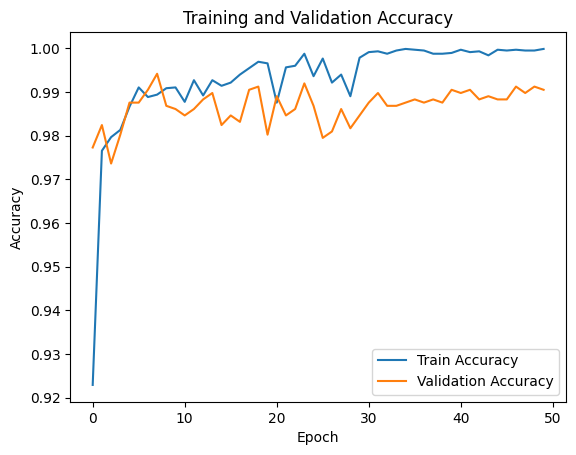

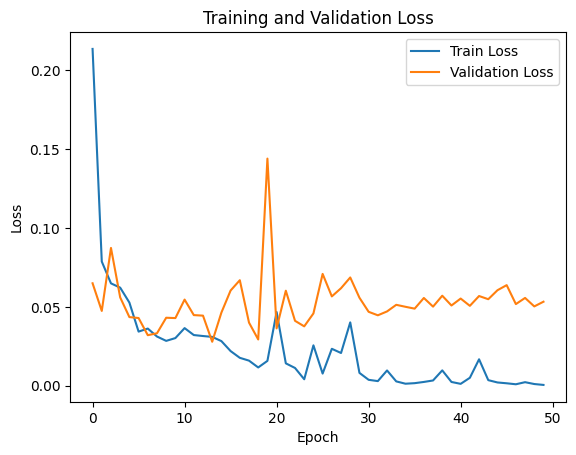

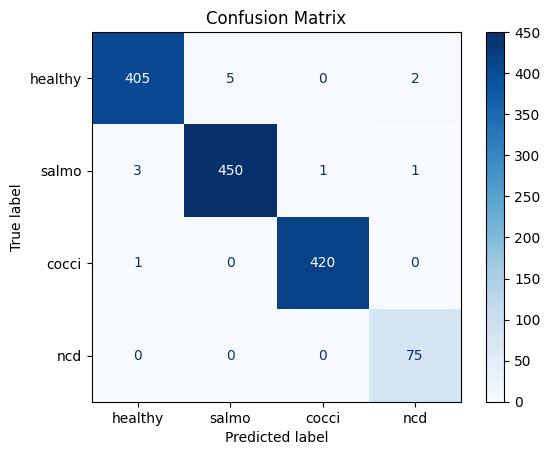

Best epoch based on validation accuracy: 7 with accuracy: 0.9941
Best epoch based on validation loss: 13 with loss: 0.0279


In [31]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Identity()

model = PoultryDiseaseClassifier()
model.to(device)

optimizer = optim.Adam([
    {'params': model.resnet50.parameters(), 'lr': LEARNING_RATE * 0.1},
    {'params': model.dense1.parameters(), 'lr': LEARNING_RATE},
    {'params': model.dropout.parameters(), 'lr': LEARNING_RATE},
    {'params': model.dense2.parameters(), 'lr': LEARNING_RATE}
])

training_history = load_checkpoint(CHECKPOINT_FILENAME, model, optimizer)

train_accuracy_history = training_history['train_accuracy_history']
accuracy_history = training_history['accuracy_history']
train_loss_history = training_history['train_loss_history']
val_loss_history = training_history['val_loss_history']
conf_matrix = training_history['conf_matrix']

plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

if isinstance(conf_matrix, list):
    last_conf_matrix = np.array(conf_matrix[-1])
else:
    last_conf_matrix = np.array(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=last_conf_matrix, display_labels=CLASS_LIST)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Finding the epoch with the highest validation accuracy

# Finding the epoch with the lowest validation loss
best_epoch_loss = np.argmin(val_loss_history)
best_val_loss = val_loss_history[best_epoch_loss]

best_epoch_accuracy = np.argmax(accuracy_history)
best_val_accuracy = accuracy_history[best_epoch_accuracy]

print(f'Best epoch based on validation accuracy: {best_epoch_accuracy} with accuracy: {best_val_accuracy:.4f}')
print(f'Best epoch based on validation loss: {best_epoch_loss} with loss: {best_val_loss:.4f}')

**Transformaciju atvaizdavimas**

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


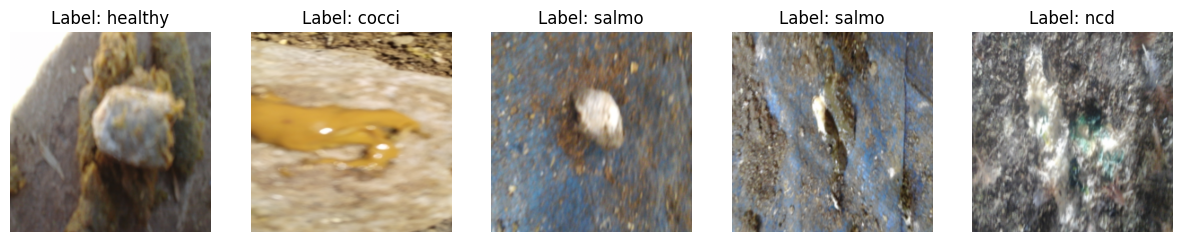

In [ ]:
def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = img * std + mean
    return img

def imshow(img, title=None):
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

INDEX_TO_CLASS = {v: k for k, v in CLASS_INDICES.items()}

dataiter = iter(test_loader)
images, labels = next(dataiter)

num_images_to_show = 5
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))
for i in range(num_images_to_show):
    ax = axes[i]
    img = denormalize(images[i], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    class_index = labels[i].argmax().item()
    class_name = INDEX_TO_CLASS[class_index]
    ax.set_title(f"Label: {class_name}")
    ax.axis('off')
plt.show()
